# Multivariate FTS applied to SONDA/Brasilia dataset

Install/update pyFTS directly from the source repository:

In [1]:
!pip install -U git+https://github.com/petroniocandido/pyFTS

  Cloning https://github.com/petroniocandido/pyFTS to /private/var/folders/13/t7d8w0nd0hv6w9_p2rntvym00000gr/T/pip-xo1hs10g-build
  Found existing installation: pyFTS 1.2.2
    Uninstalling pyFTS-1.2.2:
      Successfully uninstalled pyFTS-1.2.2
  Running setup.py install for pyFTS ... done
You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Import SONDA dataset

In [2]:
import pandas as pd
import matplotlib.pylab as plt

%pylab inline

from pyFTS.data import SONDA
df = SONDA.get_dataframe()
train = df.iloc[0:1578241] #three years
test = df.iloc[1578241:] #ears
del df

Populating the interactive namespace from numpy and matplotlib


/Users/cseveriano/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Seasonal Variables


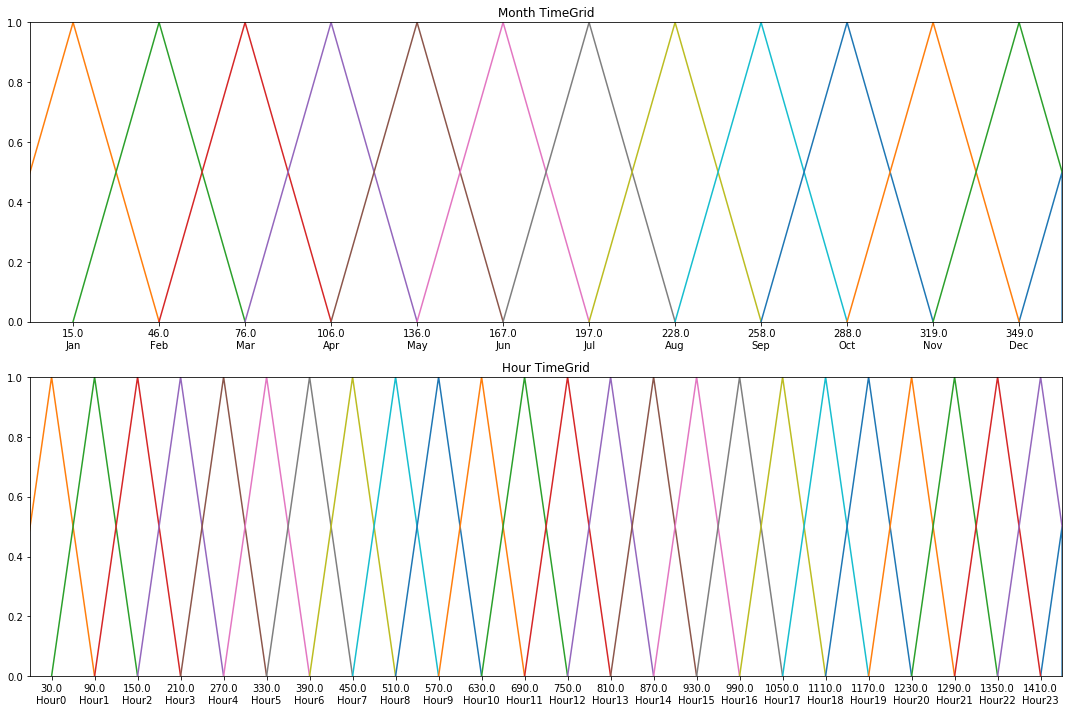

In [3]:
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.models.seasonal import partitioner as seasonal
from pyFTS.models.seasonal.common import DateTime

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=[15,10])

sp = {'seasonality': DateTime.day_of_year , 'names': ['Jan','Feb','Mar','Apr','May','Jun','Jul', 'Aug','Sep','Oct','Nov','Dec']}

vmonth = variable.Variable("Month", data_label="datahora", partitioner=seasonal.TimeGridPartitioner, npart=12, 
                           data=train, partitioner_specific=sp)
vmonth.partitioner.plot(axes[0])

sp = {'seasonality': DateTime.minute_of_day}

vhour = variable.Variable("Hour", data_label="datahora", partitioner=seasonal.TimeGridPartitioner, npart=24, 
                          data=train, partitioner_specific=sp)

vhour.partitioner.plot(axes[1])

plt.tight_layout()






## Radiance Variable, without transformation

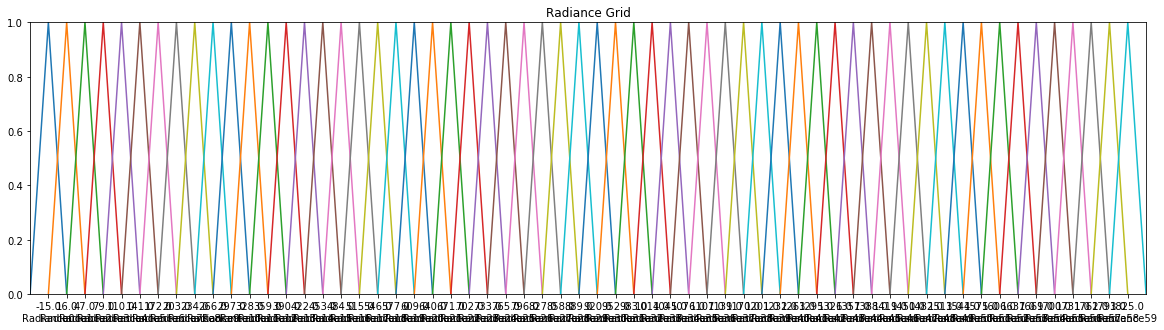

In [4]:
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=[20,5])

vavg = variable.Variable("Radiance", data_label="glo_avg", partitioner=Grid.GridPartitioner, npart=60, 
                         data=train) 
vavg.partitioner.plot(axes)



## Radiance Variable, with Differentiation

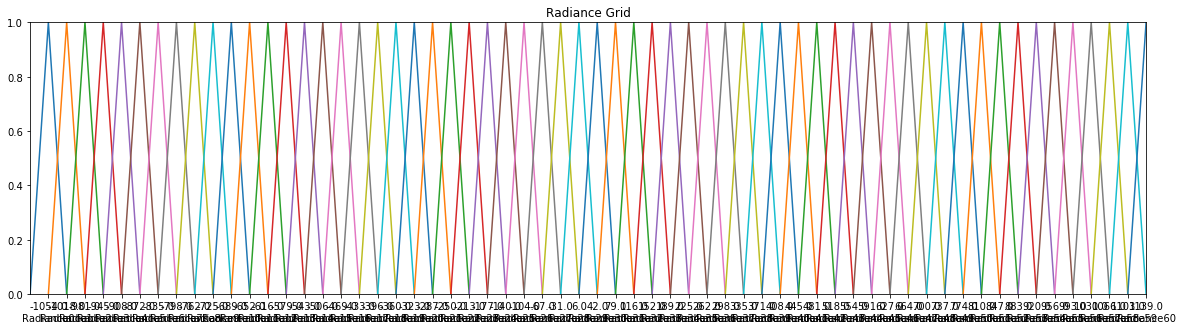

In [5]:
from pyFTS.partitioners import Grid, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts
from pyFTS.common import Transformations

bc = Transformations.BoxCox(0)
diff = Transformations.Differential(1)

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=[20,5])

vavg_diff = variable.Variable("Radiance", data_label="glo_avg", partitioner=Grid.GridPartitioner, npart=60, 
                         data=train, transformation=diff) 
vavg_diff.partitioner.plot(axes)



## MFTS model without transformations

In [6]:
from pyFTS.models.multivariate import common, variable, mvfts

model1 = mvfts.MVFTS("")

model1.append_variable(vmonth)

model1.append_variable(vhour)

model1.append_variable(vavg)

model1.target_variable = vavg

model1.fit(train, num_batches=200, save=True, batch_save=True, file_path='mvfts_sonda_gloavg', batch_save_interval=10)


KeyboardInterrupt: 

## MVFTS with differentiation

In [ ]:
from pyFTS.models.multivariate import common, variable, mvfts

model2 = mvfts.MVFTS("")

model2.append_variable(vmonth)

model2.append_variable(vhour)

model2.append_variable(vavg_diff)

model2.target_variable = vavg_diff

model2.fit(train, num_batches=200, save=True, batch_save=True, file_path='mvfts_sonda_gloavg_diff', batch_save_interval=10)


## Model Testing

Loading pre-trained models

In [ ]:
from pyFTS.common import Util

model1 = Util.load_obj('mvfts_sonda_gloavg')
model1.name = "MVFTS Normal"
model2 = Util.load_obj('mvfts_sonda_gloavg_diff')
model2.name = "MVFTS diff"


from pyFTS.data import SONDA
df = SONDA.get_dataframe()
test = df.iloc[1578241:] #ears
del df

In [40]:
teste = test.iloc[:2880]

forecasted1 = model1.predict(teste)
forecasted2 = model2.predict(teste)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[20,5])

ax.plot(teste['datahora'].values, teste['glo_avg'].values)

ax.plot(teste['datahora'].values, forecasted1)
ax.plot(teste['datahora'].values, forecasted2)


TypeError: ignored

In [ ]:
from pyFTS.benchmarks import benchmarks as bchmk

teste = test.iloc[:2880]

#bchmk.plot_compared_series(teste, [model1, model2], bchmk.colors, intervals=False)

In [38]:
!pip install -U matplotlib

    100% |████████████████████████████████| 12.5MB 107kB/s 
    100% |████████████████████████████████| 194kB 4.1MB/s 
    100% |████████████████████████████████| 512kB 2.4MB/s 
Requirement already up-to-date: six>=1.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib)
Requirement already up-to-date: cycler>=0.10 in /usr/local/lib/python3.6/dist-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib)
    100% |████████████████████████████████| 952kB 1.4MB/s 
    100% |████████████████████████████████| 12.2MB 111kB/s 
    100% |████████████████████████████████| 491kB 1.9MB/s 
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstalled python-dateutil-2.5.3
  Found existing installation: pytz 2016.7
    Uninstalling pytz-2016.7:
      Successfully uninstalled pytz-2016.7
  Found existing installation: setuptools 